In [1]:
%load_ext autoreload
%autoreload 2

In [2]:


import pandas as pd
import os
import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import climetlab as cml
import cfgrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob


#SD
from mymetrics import compute_rmse, compute_mae, compute_bias, compute_acc
from data_utils import extract_temp_pressure_level, process_and_combine
#SD

In [58]:
data_dir = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/'
fcn_dir = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/fourcastnet'
pangu_dir = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/pangu'
graphcast_dir = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/graphcast'
india_era5_12_steps = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/my_graphcast_dir/data/gcp_data/indian_region_era5_date-2022-01-01_res-0.25_levels-13_steps-12.nc'
india_era5_6days = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/my_graphcast_dir/data/gcp_data/cds-era5-india-20220101-6days.nc'


neural_gcm_data = '/Users/user/Documents_stuff/Ashoka/Capstone_Project/code/ai-models/data/forecast_data/neuralgcm'

In [4]:
lead_time = 48      # hours
init_time = 20220101 # yyyymmdd
start_time = '00'
variables = ['t']    # t: temperature
pressure_levels = [500] # 500 hPa corresponds to approx 5 km above sea level
models = ['FCN', 'pangu'] # neuralgcm

# India specific
lat_min, lat_max = 8.0, 37.0
lon_min, lon_max = 68.0, 97.0

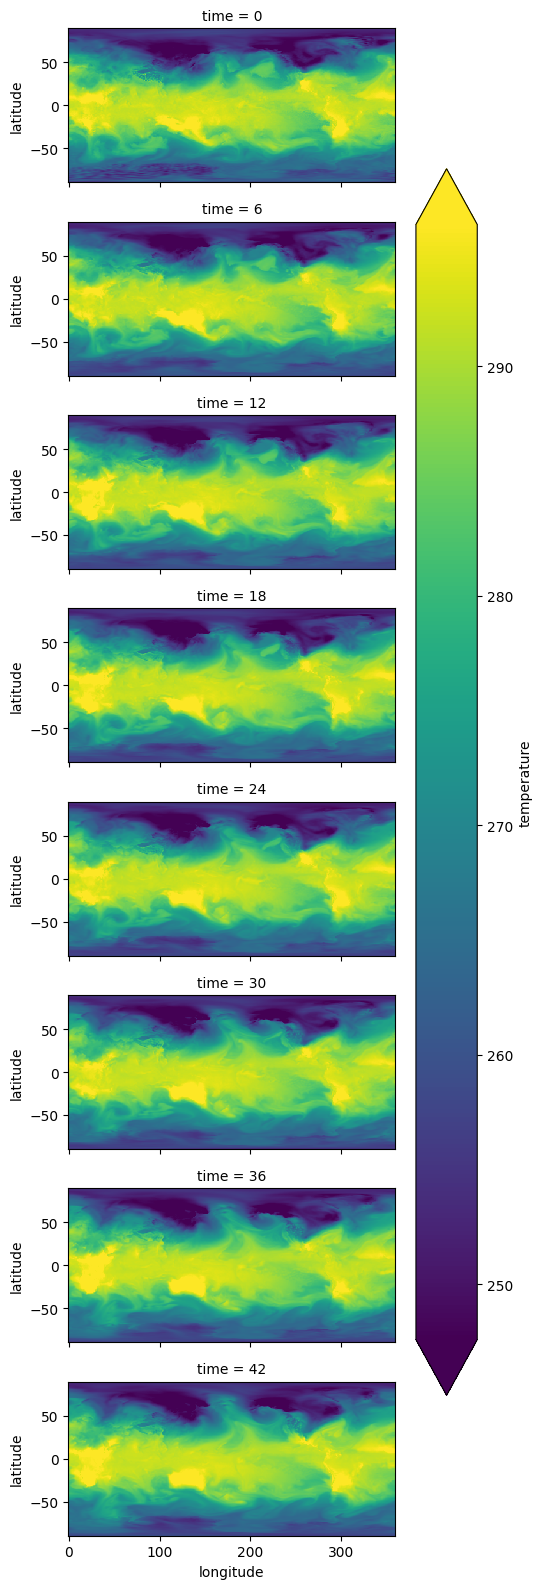

In [92]:
neural_df = xr.open_dataset(f"{neural_gcm_data}/neuralgcm_predictions_6hrs.nc")
# Visualize ERA5 vs NeuralGCM trajectories
neural_df.temperature.isel(level=31).plot(
    x='longitude', y='latitude', row='time', robust=True, aspect=2, size=2
)

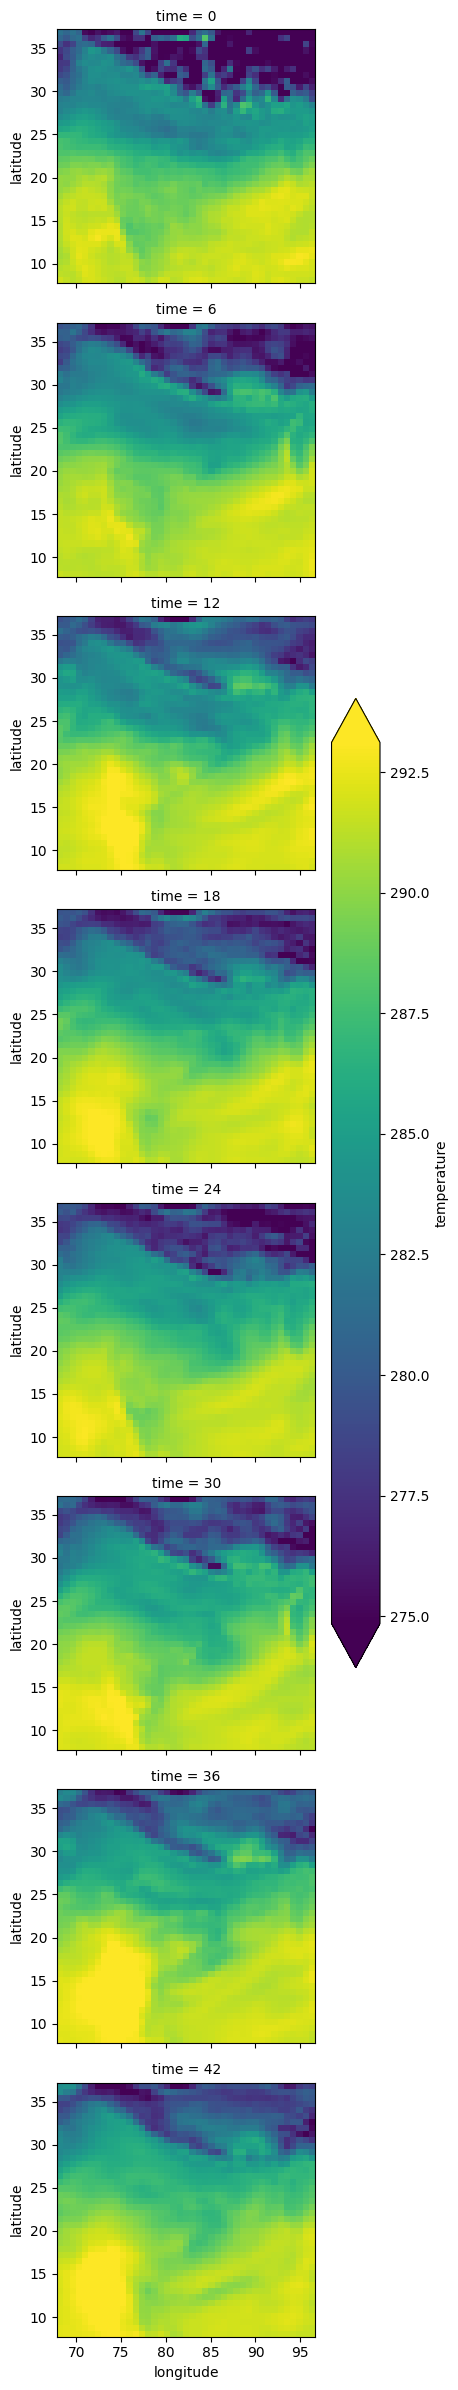

In [95]:
neural_df = neural_df.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
neural_df.temperature.isel(level=31).plot(x='longitude', y='latitude', row='time', robust=True)

In [98]:
minx = neural_df.longitude.min().item()
maxx = neural_df.longitude.max().item()
miny = neural_df.latitude.min().item()
maxy = neural_df.latitude.max().item()
new_grid_x = np.arange(
    np.ceil(minx / 0.25) * 0.25,
    (np.floor(maxx / 0.25) + 0.5) * 0.25,
    0.25
)
new_grid_y = np.arange(
    np.ceil(miny / 0.25) * 0.25,
    (np.floor(maxy / 0.25) + 0.5) * 0.25,
    0.25
)
neural_df = neural_df.interp(longitude=new_grid_x, latitude=new_grid_y, method="nearest")
neural_df

<xarray.Dataset> Size: 108MB
Dimensions:                              (level: 37, time: 8, longitude: 113,
                                          latitude: 115)
Coordinates:
  * level                                (level) int32 148B 1 2 3 ... 975 1000
  * time                                 (time) int32 32B 0 6 12 18 24 30 36 42
  * longitude                            (longitude) float64 904B 68.25 ... 9...
  * latitude                             (latitude) float64 920B 8.25 ... 36.75
Data variables:
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 15MB ...
    temperature                          (time, level, longitude, latitude) float32 15MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 15MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 15MB ...
    specific_humidity                    (time, level, longitude, latitude) float32 15MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 15MB ...
    geopotential                         (time, level, longitude, latitude) float32 15MB ...
    sim_time                             (time) float32 32B 1.979e+05 ... 1.9...
Attributes:
    longitude_wavenumbers:     256
    total_wavenumbers:         257
    longitude_nodes:           512
    latitude_nodes:            256
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonicsWithZeroImag
    spmd_mesh:                 
    centers:                   [   1    2    3    5    7   10   20   30   50 ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

In [ ]:
india_neural_df = neural_df.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
india_neural_df.to_netcdf(f"{neural_gcm_data}/india_neuralgcm_regrid_predictions_6hrs.nc")

<xarray.Dataset> Size: 108MB
Dimensions:                              (level: 37, time: 8, longitude: 113,
                                          latitude: 115)
Coordinates:
  * level                                (level) int32 148B 1 2 3 ... 975 1000
  * time                                 (time) int32 32B 0 6 12 18 24 30 36 42
  * longitude                            (longitude) float64 904B 68.25 ... 9...
  * latitude                             (latitude) float64 920B 8.25 ... 36.75
Data variables:
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 15MB ...
    temperature                          (time, level, longitude, latitude) float32 15MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 15MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 15MB ...
    specific_humidity                    (time, level, longitude, latitude) float32 15MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 15MB ...
    geopotential                         (time, level, longitude, latitude) float32 15MB ...
    sim_time                             (time) float32 32B 1.979e+05 ... 1.9...
Attributes:
    longitude_wavenumbers:     256
    total_wavenumbers:         257
    longitude_nodes:           512
    latitude_nodes:            256
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonicsWithZeroImag
    spmd_mesh:                 
    centers:                   [   1    2    3    5    7   10   20   30   50 ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

In [ ]:
india_neural_df.to_netcdf(f"{neural_gcm_data}/india_neuralgcm_regrid_predictions_20220101.nc")

In [74]:
graphcast_df = xr.open_dataset(f"{graphcast_dir}/37-graphcast-predictions_approx3days.nc")
india_graphcast = graphcast_df.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
india_graphcast.to_netcdf(f"{graphcast_dir}/india_graphcast_predictions_approx3days.nc")

In [ ]:
current_pangu_dir = f"{pangu_dir}/init{init_time}-lead{lead_time}-t{start_time}-pangu"
current_fcn_dir = f"{fcn_dir}/init{init_time}-lead{lead_time}-t{start_time}-fcn"

pangu0 = f"{pangu_dir}/init{init_time}-lead{lead_time}-t{start_time}-pangu/out-pangu-0.grib"
fcn0 = f"{fcn_dir}/init{init_time}-lead{lead_time}-t{start_time}-fcn/out-FCN-0.grib"


pangu_df_list = cfgrib.open_datasets(pangu0)
pangu_df = xr.merge(pangu_df_list, compat='override')
pangu_df

<xarray.Dataset> Size: 287MB
Dimensions:            (latitude: 721, longitude: 1440, isobaricInhPa: 13)
Coordinates:
    time               datetime64[ns] 8B 2022-01-01
    step               timedelta64[ns] 8B 00:00:00
    heightAboveGround  float64 8B 10.0
  * latitude           (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude          (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
    valid_time         datetime64[ns] 8B 2022-01-01
  * isobaricInhPa      (isobaricInhPa) float64 104B 1e+03 925.0 ... 100.0 50.0
    meanSea            float64 8B 0.0
Data variables:
    u10                (latitude, longitude) float32 4MB ...
    v10                (latitude, longitude) float32 4MB ...
    t2m                (latitude, longitude) float32 4MB ...
    z                  (isobaricInhPa, latitude, longitude) float32 54MB ...
    t                  (isobaricInhPa, latitude, longitude) float32 54MB ...
    u                  (isobaricInhPa, latitude, longitude) float32 54MB ...
    v                  (isobaricInhPa, latitude, longitude) float32 54MB ...
    q                  (isobaricInhPa, latitude, longitude) float32 54MB ...
    msl                (latitude, longitude) float32 4MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [43]:
pangu_df_list = cfgrib.open_datasets(pangu0)
pangu_df = xr.merge(pangu_df_list, compat='override')
pangu_df

<xarray.Dataset> Size: 287MB
Dimensions:            (latitude: 721, longitude: 1440, isobaricInhPa: 13)
Coordinates:
    time               datetime64[ns] 8B 2022-01-01
    step               timedelta64[ns] 8B 00:00:00
    heightAboveGround  float64 8B 10.0
  * latitude           (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude          (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
    valid_time         datetime64[ns] 8B 2022-01-01
  * isobaricInhPa      (isobaricInhPa) float64 104B 1e+03 925.0 ... 100.0 50.0
    meanSea            float64 8B 0.0
Data variables:
    u10                (latitude, longitude) float32 4MB ...
    v10                (latitude, longitude) float32 4MB ...
    t2m                (latitude, longitude) float32 4MB ...
    z                  (isobaricInhPa, latitude, longitude) float32 54MB ...
    t                  (isobaricInhPa, latitude, longitude) float32 54MB ...
    u                  (isobaricInhPa, latitude, longitude) float32 54MB ...
    v                  (isobaricInhPa, latitude, longitude) float32 54MB ...
    q                  (isobaricInhPa, latitude, longitude) float32 54MB ...
    msl                (latitude, longitude) float32 4MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [45]:
model = 'pangu'
final_df_pangu_india = pangu_df.sel(
            latitude=slice(lat_max, lat_min),
            longitude=slice(lon_min, lon_max)
        )
final_df_pangu_india

<xarray.Dataset> Size: 4MB
Dimensions:            (latitude: 117, longitude: 117, isobaricInhPa: 13)
Coordinates:
    time               datetime64[ns] 8B 2022-01-01
    step               timedelta64[ns] 8B 00:00:00
    heightAboveGround  float64 8B 10.0
  * latitude           (latitude) float64 936B 37.0 36.75 36.5 ... 8.5 8.25 8.0
  * longitude          (longitude) float64 936B 68.0 68.25 68.5 ... 96.75 97.0
    valid_time         datetime64[ns] 8B 2022-01-01
  * isobaricInhPa      (isobaricInhPa) float64 104B 1e+03 925.0 ... 100.0 50.0
    meanSea            float64 8B 0.0
Data variables:
    u10                (latitude, longitude) float32 55kB ...
    v10                (latitude, longitude) float32 55kB ...
    t2m                (latitude, longitude) float32 55kB ...
    z                  (isobaricInhPa, latitude, longitude) float32 712kB ...
    t                  (isobaricInhPa, latitude, longitude) float32 712kB ...
    u                  (isobaricInhPa, latitude, longitude) float32 712kB ...
    v                  (isobaricInhPa, latitude, longitude) float32 712kB ...
    q                  (isobaricInhPa, latitude, longitude) float32 712kB ...
    msl                (latitude, longitude) float32 55kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [49]:
if model == 'pangu':
    for i in range(6, lead_time+1, 6):
        indian_pangu_temp = xr.merge(cfgrib.open_datasets(f"{current_pangu_dir}/out-pangu-{i}.grib"), compat="override")
        indian_pangu_temp = indian_pangu_temp.sel(
            latitude=slice(lat_max, lat_min),
            longitude=slice(lon_min, lon_max)
        )
        if indian_pangu_temp is not None:
            print(indian_pangu_temp)
            final_df_pangu_india = xr.concat([final_df_pangu_india, indian_pangu_temp], dim="step")
        del indian_pangu_temp
final_df_pangu_india

<xarray.Dataset> Size: 4MB
Dimensions:            (latitude: 117, longitude: 117, isobaricInhPa: 13)
Coordinates:
    time               datetime64[ns] 8B 2022-01-01
    step               timedelta64[ns] 8B 06:00:00
    heightAboveGround  float64 8B 10.0
  * latitude           (latitude) float64 936B 37.0 36.75 36.5 ... 8.5 8.25 8.0
  * longitude          (longitude) float64 936B 68.0 68.25 68.5 ... 96.75 97.0
    valid_time         datetime64[ns] 8B 2022-01-01T06:00:00
  * isobaricInhPa      (isobaricInhPa) float64 104B 1e+03 925.0 ... 100.0 50.0
    meanSea            float64 8B 0.0
Data variables:
    u10                (latitude, longitude) float32 55kB ...
    v10                (latitude, longitude) float32 55kB ...
    t2m                (latitude, longitude) float32 55kB ...
    z                  (isobaricInhPa, latitude, longitude) float32 712kB ...
    t                  (isobaricInhPa, latitude, longitude) float32 712kB ...
    u                  (isobaricInhPa, latitude, 

<xarray.Dataset> Size: 34MB
Dimensions:            (step: 9, latitude: 117, longitude: 117,
                        isobaricInhPa: 13)
Coordinates:
    time               datetime64[ns] 8B 2022-01-01
  * step               (step) timedelta64[ns] 72B 0 days 00:00:00 ... 2 days ...
    heightAboveGround  float64 8B 10.0
  * latitude           (latitude) float64 936B 37.0 36.75 36.5 ... 8.5 8.25 8.0
  * longitude          (longitude) float64 936B 68.0 68.25 68.5 ... 96.75 97.0
    valid_time         (step) datetime64[ns] 72B 2022-01-01 ... 2022-01-03
  * isobaricInhPa      (isobaricInhPa) float64 104B 1e+03 925.0 ... 100.0 50.0
    meanSea            float64 8B 0.0
Data variables:
    u10                (step, latitude, longitude) float32 493kB 1.34 ... -7.192
    v10                (step, latitude, longitude) float32 493kB -0.8947 ... ...
    t2m                (step, latitude, longitude) float32 493kB 281.8 ... 300.2
    z                  (step, isobaricInhPa, latitude, longitude) float32 6MB ...
    t                  (step, isobaricInhPa, latitude, longitude) float32 6MB ...
    u                  (step, isobaricInhPa, latitude, longitude) float32 6MB ...
    v                  (step, isobaricInhPa, latitude, longitude) float32 6MB ...
    q                  (step, isobaricInhPa, latitude, longitude) float32 6MB ...
    msl                (step, latitude, longitude) float32 493kB 1.019e+05 .....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [50]:
final_df_pangu_india.to_netcdf(f"{current_pangu_dir}/india_pangu_all42.nc")

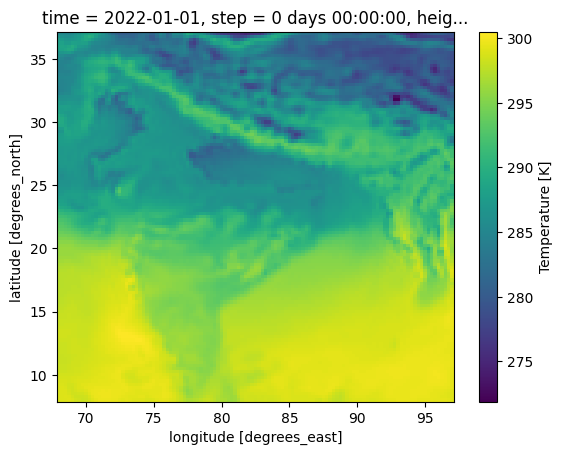

In [51]:
final_df_pangu_india['t'].isel(step=0,isobaricInhPa=0 ).plot()

In [ ]:
fcn_df_list = cfgrib.open_datasets(fcn0)
fcn_df_list
fcn_df = xr.merge(fcn_df_list, compat='override')
fcn_df

<xarray.Dataset> Size: 141MB
Dimensions:            (latitude: 721, longitude: 1440, isobaricInhPa: 5)
Coordinates:
    time               datetime64[ns] 8B 2022-01-01
    step               timedelta64[ns] 8B 00:00:00
    entireAtmosphere   float64 8B 0.0
  * latitude           (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude          (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
    valid_time         datetime64[ns] 8B ...
    heightAboveGround  float64 8B 10.0
  * isobaricInhPa      (isobaricInhPa) float64 40B 50.0 250.0 500.0 850.0 1e+03
    meanSea            float64 8B 0.0
    surface            float64 8B 0.0
Data variables: (12/14)
    tcwv               (latitude, longitude) float32 4MB ...
    u10                (latitude, longitude) float32 4MB ...
    v10                (latitude, longitude) float32 4MB ...
    t2m                (latitude, longitude) float32 4MB ...
    u100               (latitude, longitude) float32 4MB ...
    v100               (latitude, longitude) float32 4MB ...
    ...                 ...
    u                  (isobaricInhPa, latitude, longitude) float32 21MB nan ...
    v                  (isobaricInhPa, latitude, longitude) float32 21MB nan ...
    r                  (isobaricInhPa, latitude, longitude) float32 21MB nan ...
    msl                (latitude, longitude) float32 4MB ...
    sp                 (latitude, longitude) float32 4MB ...
    tp                 (latitude, longitude) float32 4MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [13]:
model = 'fcn'
final_df_fcn_india = fcn_df.sel(
            latitude=slice(lat_max, lat_min),
            longitude=slice(lon_min, lon_max)
        )
final_df_fcn_india

<xarray.Dataset> Size: 2MB
Dimensions:            (latitude: 117, longitude: 117, isobaricInhPa: 5)
Coordinates:
    time               datetime64[ns] 8B 2022-01-01
    step               timedelta64[ns] 8B 00:00:00
    entireAtmosphere   float64 8B 0.0
  * latitude           (latitude) float64 936B 37.0 36.75 36.5 ... 8.5 8.25 8.0
  * longitude          (longitude) float64 936B 68.0 68.25 68.5 ... 96.75 97.0
    valid_time         datetime64[ns] 8B ...
    heightAboveGround  float64 8B 10.0
  * isobaricInhPa      (isobaricInhPa) float64 40B 50.0 250.0 500.0 850.0 1e+03
    meanSea            float64 8B 0.0
    surface            float64 8B 0.0
Data variables: (12/14)
    tcwv               (latitude, longitude) float32 55kB ...
    u10                (latitude, longitude) float32 55kB ...
    v10                (latitude, longitude) float32 55kB ...
    t2m                (latitude, longitude) float32 55kB ...
    u100               (latitude, longitude) float32 55kB ...
    v100               (latitude, longitude) float32 55kB ...
    ...                 ...
    u                  (isobaricInhPa, latitude, longitude) float32 274kB nan...
    v                  (isobaricInhPa, latitude, longitude) float32 274kB nan...
    r                  (isobaricInhPa, latitude, longitude) float32 274kB nan...
    msl                (latitude, longitude) float32 55kB ...
    sp                 (latitude, longitude) float32 55kB ...
    tp                 (latitude, longitude) float32 55kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [ ]:
if model == 'fcn':
    for i in range(6, lead_time, 6):
        fcn_df_temp = xr.merge(cfgrib.open_datasets(f"{current_fcn_dir}/out-FCN-{i}.grib"), compat="override")
        indian_fcn_temp = fcn_df_temp.sel(
            latitude=slice(lat_max, lat_min),
            longitude=slice(lon_min, lon_max)
        )
        if fcn_df_temp is not None:
            print(fcn_df_temp)
            final_df_fcn_india = xr.concat([final_df_fcn_india, indian_fcn_temp], dim="step")
del fcn_df_temp
final_df_fcn_india

In [10]:
indian_pangu = final_df.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max)
)
indian_pangu.to_netcdf(f"{current_pangu_dir}/indian_pangu120.nc")

NameError: name 'final_df' is not defined

In [11]:
final_df_fcn_india.to_netcdf(f"{current_fcn_dir}/indian_FCN_120.nc")

In [63]:
indian_pangu

<xarray.Dataset> Size: 76MB
Dimensions:            (step: 20, latitude: 117, longitude: 117,
                        isobaricInhPa: 13)
Coordinates:
    time               datetime64[ns] 8B 2022-01-01
  * step               (step) timedelta64[ns] 160B 0 days 00:00:00 ... 4 days...
    heightAboveGround  float64 8B 10.0
  * latitude           (latitude) float64 936B 37.0 36.75 36.5 ... 8.5 8.25 8.0
  * longitude          (longitude) float64 936B 68.0 68.25 68.5 ... 96.75 97.0
    valid_time         (step) datetime64[ns] 160B 2022-01-01 ... 2022-01-05T1...
  * isobaricInhPa      (isobaricInhPa) float64 104B 1e+03 925.0 ... 100.0 50.0
    meanSea            float64 8B 0.0
Data variables:
    u10                (step, latitude, longitude) float32 1MB 1.34 ... -2.56
    v10                (step, latitude, longitude) float32 1MB -0.8947 ... -1...
    t2m                (step, latitude, longitude) float32 1MB 281.8 ... 299.8
    z                  (step, isobaricInhPa, latitude, longitude) float32 14MB ...
    t                  (step, isobaricInhPa, latitude, longitude) float32 14MB ...
    u                  (step, isobaricInhPa, latitude, longitude) float32 14MB ...
    v                  (step, isobaricInhPa, latitude, longitude) float32 14MB ...
    q                  (step, isobaricInhPa, latitude, longitude) float32 14MB ...
    msl                (step, latitude, longitude) float32 1MB 1.019e+05 ... ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [ ]:
for model in models:
    for level in pressure_levels:
        for var in variables:
            if model == 'FCN':
                model = 'FCNv2'
                forecast_path = os.path.join(fcn_dir, 'init20220101-lead120-t00-fcn')
            elif model == 'pangu':
                forecast_path = os.path.join(pangu_dir, 'init20220101-lead120-t00-pangu')
            elif model == 'graphcast':
                # all the graphcast forecast data is in one file so the processing isn't needed for that
                forecast_path = os.path.join(graphcast_dir, f'{model}_forecast_{var}_{level}hPa_{init_time}_{lead_time}.nc')
            else:
                raise ValueError('Invalid model name')
            # print(forecast_path)
            # data = xr.open_dataset(forecast_path)
            forecast_df = extract_temp_pressure_level(f'{forecast_path}/out-{model}-0.grib', var, level)
            for i in range(6, lead_time+1, 6):
                # print(f"{forecast_path}/out-{model}-{i}.grib")
                # pangu_df_temp = extract_temp_pressure_level(f"{pangu_dir}/out-pangu-{i}.grib",'t', '500')
                # pangu_df = xr.concat([pangu_df, pangu_df_temp], dim="step")
                # del pangu_df_temp
                pass